In [1]:
driver_name = '../'

In [2]:
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

from keras import layers, models
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

from rdkit import Chem, DataStructs, rdBase
from rdkit.Chem import AllChem, DataStructs, Draw, rdDistGeom
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprint, GetMorganFingerprintAsBitVect
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
from rdkit.Chem.Draw import IPythonConsole
from rdkit import RDLogger
RDLogger.logger().setLevel(RDLogger.CRITICAL)

In [3]:
def distij( i, j, fps ) :
    return 1 - DataStructs.DiceSimilarity( fps[i], fps[j] )


def diversePicker( fps ) :
    nfps = len(fps)
    picker = MaxMinPicker()
    pickIndices = picker.LazyPick( distij, nfps, 10, seed=23 )
    list(pickIndices)
    

def readAndSplitMolecules_1( fname, frac_test ) :
    molsdf = Chem.rdmolfiles.SDMolSupplier( fname )
    moles = [ m for m in molsdf if m != None ]
    fps = [GetMorganFingerprint(x,3) for x in moles]
    diversePicker( fps )

In [4]:
def readAndSplitMolecules( fname, frac_test ) :
    molsdf = Chem.rdmolfiles.SDMolSupplier( fname )
    moles = [ m for m in molsdf if m != None ]
    moles_train, moles_test = train_test_split( moles, test_size=frac_test )
    print( "%d-molecules = %d-train + %d-test" % ( len(molsdf), len(moles_train), len(moles_test) ) )
    return moles_train, moles_test

In [5]:
def getFingerprintFromMolecule( moles, nBits=2048 ) :
    fps = [ GetMorganFingerprintAsBitVect( m, radius=2, nBits=nBits ) for m in moles ]
    np_fps = []
    for fp in fps:
        arr = np.zeros( (1, ) )
        DataStructs.cDataStructs.ConvertToNumpyArray( fp, arr )
        np_fps.append( arr )
    return np_fps

In [6]:
def getActivityOfMolecule( moles ) :
    try:
        activity = [ m.GetProp( 'pChEMBL_Value' ) for m in moles ]
        activity = np.asarray( activity ).astype( 'float' )
    except :
        print( "No activity data..." )
        activity = np.array( len(moles) )
    return activity

In [7]:
def generateInputDataRegres( moles, nBits=2048 ) :
    fps = np.array( getFingerprintFromMolecule( moles, nBits ) )
    y = getActivityOfMolecule( moles )
    return fps, y

In [8]:
def do_regression( X_train, Y_train, epochs=200, validation_split=0.1 ):
    nfeatures = X_train.shape[1]
    model = Sequential()
    model.add(Dense(nfeatures, input_dim=nfeatures, activation='relu'))
    model.add(Dense(nfeatures, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'] )
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=64, validation_split=validation_split, verbose=1)
    return model, history

In [9]:
def plot_history( hist ) :
    plt.figure( figsize=(6, 4) )
    _, loss_ax = plt.subplots()
    _ = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper right')

    plt.show()

In [10]:
def plot_prediction( Y_train, Y_train_pred, Y_test, Y_test_pred ) :
    plt.figure( figsize=(4, 4) )
    plt.scatter(Y_train, Y_train_pred, color='black', s=2)
    plt.scatter(Y_test, Y_test_pred, color='red', s=2)
    plt.xticks( np.arange(3, 12) )
    plt.yticks( np.arange(3, 12) )
    plt.show()

In [11]:
def check_duplicates( fps ) :
    fps2 = np.unique( [ tuple(row) for row in fps ] )
    print( len(fps), len(fps2) )

In [12]:
def MakePredictionModel( sdfname, nBits, frac_test, epochs, fname_model ) :
    #readAndSplitMolecules_1( sdfname, frac_test )
    moles_train, moles_test = readAndSplitMolecules( sdfname, frac_test )
    fps_train, activity_train = generateInputDataRegres( moles_train, nBits )
    fps_test,  activity_test  = generateInputDataRegres( moles_test,  nBits )
#check_duplicates( fps_train )

    model, history = do_regression( fps_train, activity_train, epochs=epochs, validation_split=0.1 )
    model.save( fname_model )

    plot_history( history )

    activity_train_pred = model.predict( fps_train ).flatten()
    activity_test_pred  = model.predict( fps_test ).flatten()

    plot_prediction( activity_train, activity_train_pred, activity_test, activity_test_pred )

In [13]:
def UsePredictionModel( model, dbfname, nBits ) :
    mdb = Chem.rdmolfiles.SmilesMolSupplier( dbfname )
    moles = [ m for m in mdb if m != None ][6000:9000]
    #fps = getFingerprintFromMolecule( moles )
    print( 'Start searching ...' )
    result = []
    for m in moles :
        fp = GetMorganFingerprintAsBitVect( m, radius=2, nBits=nBits )
        fps = np.zeros( (1, ) )
        DataStructs.cDataStructs.ConvertToNumpyArray( fp, fps )
        yp = model.predict( fps.reshape(1,-1) )[0]
        if 7.5 < yp :
            print( "%5.2f : %s" % ( yp, Chem.MolToSmiles(m) ) )
            result.append( m )
            
    return result

In [ ]:
nBits = 1024
fname_model = driver_name + 'data/egfr/ChEMBL-EGFR-2664-model.save'

if not os.path.exists( fname_model ) :
    frac_test = 0.3
    epochs = 100
    sdfname = driver_name + 'data/egfr/200609-ChEMBL-2664.sdf'
    MakePredictionModel( sdfname, nBits, frac_test, epochs, fname_model )

if os.path.exists( fname_model ) :
    dbfname = driver_name + 'data/egfr/emolecules-10k.smi'
    model = models.load_model( fname_model )
    result = UsePredictionModel( model, dbfname, nBits )
    
    Draw.MolsToGridImage( result[:20], molsPerRow=4, subImgSize=(250,250) )    

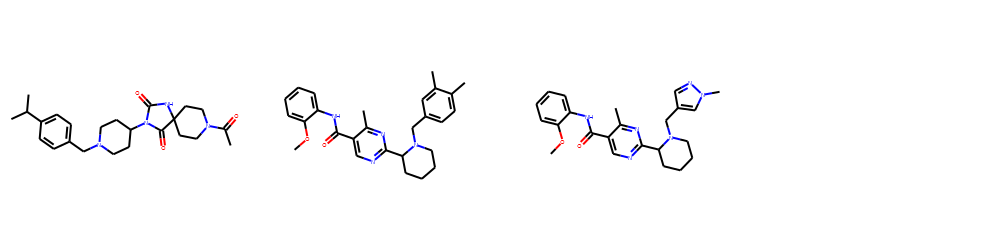

In [15]:
Draw.MolsToGridImage( result, molsPerRow=4, subImgSize=(250,250) )    